# ✅ Загрузка датасета

In [ ]:
!wget https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/8p2hvgdvpn-1.zip
!unzip 8p2hvgdvpn-1.zip -d data/
!unzip "data/Chemical Apparatus Image Dataset.zip" -d data/

In [23]:
!find "data/Chemical Apparatus Image Dataset" -type d | sort

data/Chemical Apparatus Image Dataset
data/Chemical Apparatus Image Dataset/Test
data/Chemical Apparatus Image Dataset/Test/Images
data/Chemical Apparatus Image Dataset/Test/Labels
data/Chemical Apparatus Image Dataset/Train
data/Chemical Apparatus Image Dataset/Train/Images
data/Chemical Apparatus Image Dataset/Train/Labels
data/Chemical Apparatus Image Dataset/Valid
data/Chemical Apparatus Image Dataset/Valid/Images
data/Chemical Apparatus Image Dataset/Valid/Labels
data/Chemical Apparatus Image Dataset/Valid/Labels/.ipynb_checkpoints


# ✅ Загрузка весов

In [27]:
!mkdir -p weights && wget https://dl.fbaipublicfiles.com/detectron2/ImageNetPretrained/MSRA/R-50.pkl -O weights/R-50.pkl

--2025-06-12 18:19:28--  https://dl.fbaipublicfiles.com/detectron2/ImageNetPretrained/MSRA/R-50.pkl
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.165.140.34, 18.165.140.51, 18.165.140.57, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.165.140.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 102465407 (98M) [application/octet-stream]
Saving to: ‘weights/R-50.pkl’

weights/R-50.pkl    100%[===================>]  97.72M  10.5MB/s    in 9.4s    

2025-06-12 18:19:36 (10.4 MB/s) - ‘weights/R-50.pkl’ saved [102465407/102465407]



# ✅ Установка detectron2

In [1]:
!uv pip install pyyaml==5.1
import sys, os, distutils.core
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!uv pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

from detectron2.utils.logger import setup_logger
setup_logger()

Audited 1 package in 2ms
fatal: destination path 'detectron2' already exists and is not an empty directory.
Audited 12 packages in 16ms


/home/andrei/dev/cv/.venv/lib/python3.12/site-packages/setuptools/config/_apply_pyprojecttoml.py:75: _MissingDynamic: `authors` defined outside of `pyproject.toml` is ignored.
!!

        ********************************************************************************
        The following seems to be defined outside of `pyproject.toml`:

        `authors = 'FAIR'`

        According to the spec (see the link below), however, setuptools CANNOT
        consider this value unless `authors` is listed as `dynamic`.

        https://packaging.python.org/en/latest/specifications/pyproject-toml/#declaring-project-metadata-the-project-table

        To prevent this problem, you can list `authors` under `dynamic` or alternatively
        remove the `[project]` table from your file and rely entirely on other means of
        configuration.
        ********************************************************************************

!!
  _handle_missing_dynamic(dist, project_table)
/home/andrei/dev/c

/bin/bash: line 1: nvcc: command not found
torch:  2.7 ; cuda:  cu126
detectron2: 0.6


<Logger detectron2 (DEBUG)>

# ✅ Импорты

In [2]:
import os, cv2, random
import torch
import numpy as np
import pandas as pd
from detectron2.utils.visualizer import Visualizer
from detectron2.engine import DefaultTrainer
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.config import get_cfg
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

matplotlib data path: /home/andrei/dev/cv/.venv/lib/python3.12/site-packages/matplotlib/mpl-data
CONFIGDIR=/root/.config/matplotlib
interactive is False
platform is linux
CACHEDIR=/root/.cache/matplotlib
Using fontManager instance from /root/.cache/matplotlib/fontlist-v390.json


# ✅ Конвертация YOLO → COCO (1 раз)

In [12]:
import json
from glob import glob
from PIL import Image

def yolo_to_coco(images_dir, labels_dir, output_json_path):
    coco_images = []
    annotations = []
    categories = [{"id": i, "name": str(i)} for i in range(7)]  # 7 классов: 0–6
    ann_id = 1
    image_id = 1

    cat_map = {str(cat["name"]): cat["id"] for cat in categories}

    for img_name in os.listdir(images_dir):
        if not img_name.endswith(".jpg") and not img_name.endswith(".png"):
            continue
        img_path = os.path.join(images_dir, img_name)
        label_path = os.path.join(labels_dir, os.path.splitext(img_name)[0] + ".txt")

        if not os.path.exists(label_path):
            continue

        img = cv2.imread(img_path)
        height, width = img.shape[:2]

        coco_images.append({
            "id": image_id,
            "file_name": img_name,
            "height": height,
            "width": width
        })

        with open(label_path, 'r') as f:
            for line in f.readlines():
                parts = line.strip().split()
                if len(parts) != 5:
                    continue
                class_id, xc, yc, w, h = map(float, parts)
                if int(class_id) not in cat_map.values():
                    continue  # игнорировать классы вне 0–6

                bbox_width = w * width
                bbox_height = h * height
                x0 = (xc * width) - bbox_width / 2
                y0 = (yc * height) - bbox_height / 2

                annotations.append({
                    "id": ann_id,
                    "image_id": image_id,
                    "category_id": int(class_id),
                    "bbox": [x0, y0, bbox_width, bbox_height],
                    "area": bbox_width * bbox_height,
                    "iscrowd": 0
                })
                ann_id += 1
        image_id += 1

    coco_json = {
        "info": {
            "description": "Chemical Apparatus Dataset",
            "url": "",
            "version": "1.0",
            "year": 2025,
            "contributor": "",
            "date_created": "2025-06-12"
        },
        "licenses": [],
        "images": coco_images,
        "annotations": annotations,
        "categories": categories
    }

    with open(output_json_path, 'w') as f:
        json.dump(coco_json, f)

# 🔁 Конвертируем данные
os.makedirs("coco", exist_ok=True)
yolo_to_coco("data/Chemical Apparatus Image Dataset/Train/Images", "data/Chemical Apparatus Image Dataset/Train/Labels", "coco/train.json")
yolo_to_coco("data/Chemical Apparatus Image Dataset/Valid/Images", "data/Chemical Apparatus Image Dataset/Valid/Labels", "coco/val.json")

# 📦 Регистрируем датасеты

In [3]:
register_coco_instances("chemical_train", {}, "coco/train.json", "data/Chemical Apparatus Image Dataset/Train/Images")
register_coco_instances("chemical_val", {}, "coco/val.json", "data/Chemical Apparatus Image Dataset/Valid/Images")

# ⚙️ Настройка модели

In [4]:
cfg = get_cfg()
cfg.merge_from_file("detectron2/configs/COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml")
cfg.DATASETS.TRAIN = ("chemical_train",)
cfg.DATASETS.TEST = ("chemical_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "./weights/R-50.pkl"
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.MAX_ITER = 300
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 7

# 🚀 Обучение

In [5]:
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[06/12 17:21:13 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
The checkpoint state_dict contains keys that are not used by the model:
  fc1000.{bias, weight}
  stem.conv1.bias


[06/12 17:21:14 d2.engine.train_loop]: Starting training from iteration 0


/home/andrei/dev/cv/.venv/lib/python3.12/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4314.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[06/12 17:21:23 d2.utils.events]:  eta: 0:02:19  iter: 19  total_loss: 1.909  loss_cls: 1.165  loss_box_reg: 0.003359  loss_rpn_cls: 0.6992  loss_rpn_loc: 0.02444    time: 0.4923  last_time: 0.4983  data_time: 0.0181  last_data_time: 0.0093   lr: 6.427e-05  max_mem: 2547M
[06/12 17:21:33 d2.utils.events]:  eta: 0:02:09  iter: 39  total_loss: 0.7948  loss_cls: 0.1308  loss_box_reg: 0.002953  loss_rpn_cls: 0.6062  loss_rpn_loc: 0.02151    time: 0.4943  last_time: 0.4268  data_time: 0.0092  last_data_time: 0.0088   lr: 0.00013087  max_mem: 2547M
[06/12 17:21:43 d2.utils.events]:  eta: 0:01:58  iter: 59  total_loss: 0.8459  loss_cls: 0.3077  loss_box_reg: 0.09362  loss_rpn_cls: 0.4402  loss_rpn_loc: 0.02128    time: 0.4875  last_time: 0.5016  data_time: 0.0089  last_data_time: 0.0093   lr: 0.00019747  max_mem: 2547M
[06/12 17:21:51 d2.utils.events]:  eta: 0:01:48  iter: 79  total_loss: 0.807  loss_cls: 0.3953  loss_box_reg: 0.1235  loss_rpn_cls: 0.2449  loss_rpn_loc: 0.02864    time: 0.487

# 📊 Оценка

In [6]:
evaluator = COCOEvaluator("chemical_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "chemical_val")
inference_on_dataset(trainer.model, val_loader, evaluator)

[06/12 17:23:33 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [06/12 17:23:33 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/12 17:23:33 d2.data.datasets.coco]: Loaded 570 images in COCO format from coco/val.json
[06/12 17:23:34 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/12 17:23:34 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[06/12 17:23:34 d2.data.common]: Serializing 570 elements to byte tensors and concatenating them all ...
[06/12 17:23:34 d2.data.common]: Serialized dataset takes 0.22 MiB
[06/12 17:23:34 d2.evaluation.evaluator]: Start inference on 570 batches
[06/12 17:23:35 d2.evaluation.evaluator]: Inference done 11/570. Dataloading: 0.0022 s/iter. Inference: 0.1238 s/it

OrderedDict([('bbox',
              {'AP': 7.856323963782387,
               'AP50': 23.651953565701316,
               'AP75': 1.759277654687787,
               'APs': nan,
               'APm': 0.20725705564068916,
               'APl': 8.115657442474888,
               'AP-0': 4.855922741641983,
               'AP-1': 4.841176727461463,
               'AP-2': 11.597119511048612,
               'AP-3': 21.647693919065457,
               'AP-4': 0.47086676976285796,
               'AP-5': 6.810176557204037,
               'AP-6': 4.7713115202923015})])

# ⚙️ Оптимизация модели

In [10]:
cfg_opt = get_cfg()
cfg_opt.merge_from_file("detectron2/configs/COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml")
cfg_opt.DATASETS.TRAIN = ("chemical_train",)
cfg_opt.DATASETS.TEST = ("chemical_val",)
cfg_opt.DATALOADER.NUM_WORKERS = 2
cfg_opt.MODEL.WEIGHTS = "./weights/R-50.pkl"
cfg_opt.SOLVER.IMS_PER_BATCH = 4 # Было 2
cfg_opt.SOLVER.BASE_LR = 0.0005 # Было 0.001
cfg_opt.SOLVER.MAX_ITER = 500 # Было 300
cfg_opt.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg_opt.MODEL.ROI_HEADS.NUM_CLASSES = 7
cfg_opt.OUTPUT_DIR = "./output_opt"

# 🚀 Обучение оптимизированной модели

In [11]:
trainer_opt = DefaultTrainer(cfg_opt)
trainer_opt.resume_or_load(resume=False)
trainer_opt.train()

[06/12 17:47:06 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
The checkpoint state_dict contains keys that are not used by the model:
  fc1000.{bias, weight}
  stem.conv1.bias


[06/12 17:47:07 d2.engine.train_loop]: Starting training from iteration 0
[06/12 17:47:25 d2.utils.events]:  eta: 0:07:48  iter: 19  total_loss: 2.414  loss_cls: 1.684  loss_box_reg: 0.003285  loss_rpn_cls: 0.703  loss_rpn_loc: 0.02573    time: 0.9840  last_time: 0.9979  data_time: 0.0374  last_data_time: 0.0188   lr: 1.9481e-05  max_mem: 5167M
[06/12 17:47:44 d2.utils.events]:  eta: 0:07:32  iter: 39  total_loss: 0.9464  loss_cls: 0.1888  loss_box_reg: 0.003212  loss_rpn_cls: 0.6787  loss_rpn_loc: 0.03253    time: 1.0138  last_time: 0.8444  data_time: 0.0187  last_data_time: 0.0185   lr: 3.9461e-05  max_mem: 5168M
[06/12 17:48:03 d2.utils.events]:  eta: 0:07:07  iter: 59  total_loss: 0.8505  loss_cls: 0.1846  loss_box_reg: 0.0253  loss_rpn_cls: 0.6273  loss_rpn_loc: 0.0268    time: 0.9912  last_time: 0.9567  data_time: 0.0183  last_data_time: 0.0186   lr: 5.9441e-05  max_mem: 5168M
[06/12 17:48:21 d2.utils.events]:  eta: 0:06:47  iter: 79  total_loss: 1.04  loss_cls: 0.3327  loss_box_

# 📊 Оценка оптимизированной модели

In [12]:
evaluator_opt = COCOEvaluator("chemical_val", output_dir="./output_opt")
val_loader_opt = build_detection_test_loader(cfg_opt, "chemical_val")
inference_on_dataset(trainer_opt.model, val_loader_opt, evaluator_opt)

[06/12 17:54:45 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [06/12 17:54:45 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/12 17:54:45 d2.data.datasets.coco]: Loaded 570 images in COCO format from coco/val.json
[06/12 17:54:45 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/12 17:54:45 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[06/12 17:54:45 d2.data.common]: Serializing 570 elements to byte tensors and concatenating them all ...
[06/12 17:54:45 d2.data.common]: Serialized dataset takes 0.22 MiB
[06/12 17:54:45 d2.evaluation.evaluator]: Start inference on 570 batches
[06/12 17:54:47 d2.evaluation.evaluator]: Inference done 11/570. Dataloading: 0.0020 s/iter. Inference: 0.1260 s/it

OrderedDict([('bbox',
              {'AP': 12.514947951733832,
               'AP50': 33.426311116850584,
               'AP75': 5.766688976112369,
               'APs': nan,
               'APm': 0.0,
               'APl': 12.907679977851643,
               'AP-0': 7.872130008632936,
               'AP-1': 6.95039402471283,
               'AP-2': 16.896833591358522,
               'AP-3': 30.18291211291566,
               'AP-4': 0.4775876624858167,
               'AP-5': 13.631398921977715,
               'AP-6': 11.59337934005333})])

# 📊 Сравнение Loss по итерациям полученных моделей

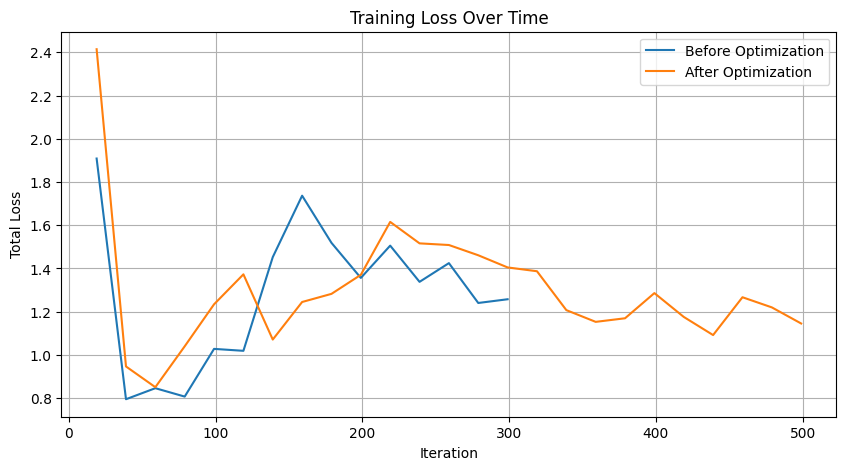

In [14]:
import json
import matplotlib.pyplot as plt

def plot_loss_curve(json_path, label):
    iters, losses = [], []
    with open(json_path) as f:
        for line in f:
            record = json.loads(line)
            if "total_loss" in record:
                iters.append(record["iteration"])
                losses.append(record["total_loss"])
    plt.plot(iters, losses, label=label)

plt.figure(figsize=(10, 5))
plot_loss_curve("output/metrics.json", label="Before Optimization")
plot_loss_curve("output_opt/metrics.json", label="After Optimization")
plt.xlabel("Iteration")
plt.ylabel("Total Loss")
plt.title("Training Loss Over Time")
plt.legend()
plt.grid(True)
plt.show()

# 📊 Сравнение ключевых метрик полученных моделей

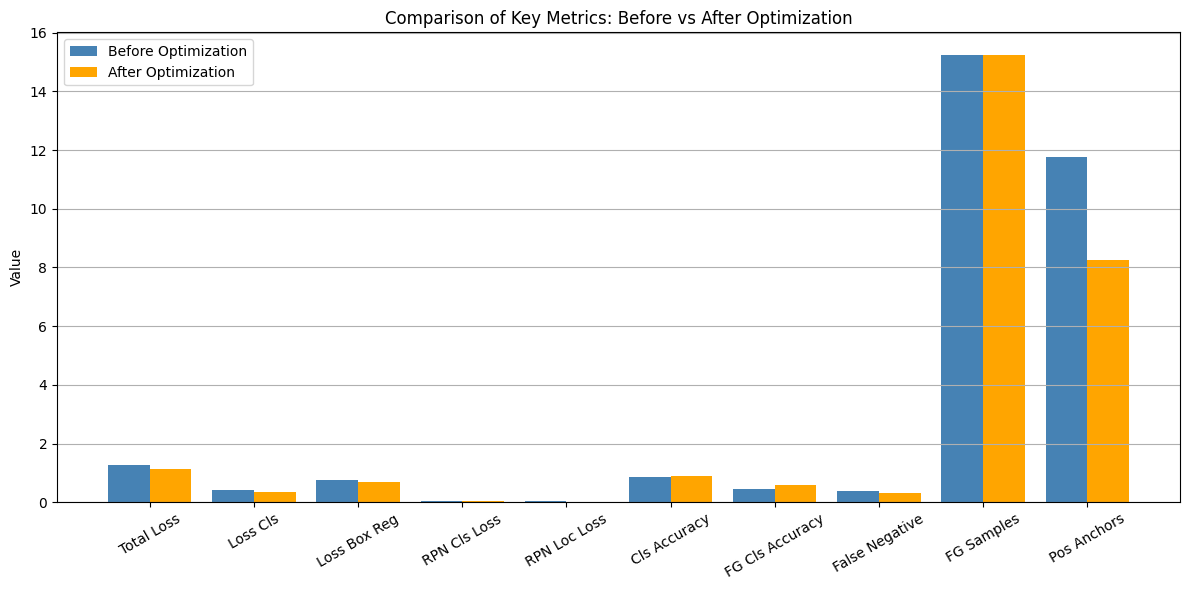

In [20]:
import json
import matplotlib.pyplot as plt

def extract_last_metrics(json_path, keys):
    with open(json_path) as f:
        data = [json.loads(line) for line in f if line.strip().startswith('{')]
    last = data[-1]
    return [last.get(k, 0.0) for k in keys]

# Пути к файлам
before_path = "output/metrics.json"
after_path = "output_opt/metrics.json"

# Метрики
metrics_keys = [
    "total_loss",
    "loss_cls",
    "loss_box_reg",
    "loss_rpn_cls",
    "loss_rpn_loc",
    "fast_rcnn/cls_accuracy",
    "fast_rcnn/fg_cls_accuracy",
    "fast_rcnn/false_negative",
    "roi_head/num_fg_samples",
    "rpn/num_pos_anchors"
]

labels = [
    "Total Loss",
    "Loss Cls",
    "Loss Box Reg",
    "RPN Cls Loss",
    "RPN Loc Loss",
    "Cls Accuracy",
    "FG Cls Accuracy",
    "False Negative",
    "FG Samples",
    "Pos Anchors"
]

# Извлекаем метрики
before_values = extract_last_metrics(before_path, metrics_keys)
after_values = extract_last_metrics(after_path, metrics_keys)

# Построение графика
x = range(len(labels))
plt.figure(figsize=(12, 6))
plt.bar([i - 0.2 for i in x], before_values, width=0.4, label="Before Optimization", color="steelblue")
plt.bar([i + 0.2 for i in x], after_values, width=0.4, label="After Optimization", color="orange")
plt.xticks(x, labels, rotation=30)
plt.ylabel("Value")
plt.title("Comparison of Key Metrics: Before vs After Optimization")
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# 🎨 Визуализация на примере из Valid

WARNING [06/12 18:14:16 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/12 18:14:16 d2.data.datasets.coco]: Loaded 570 images in COCO format from coco/val.json


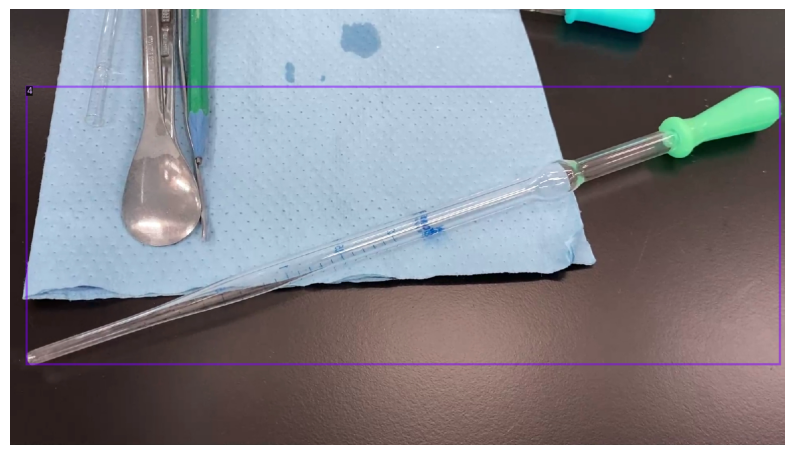

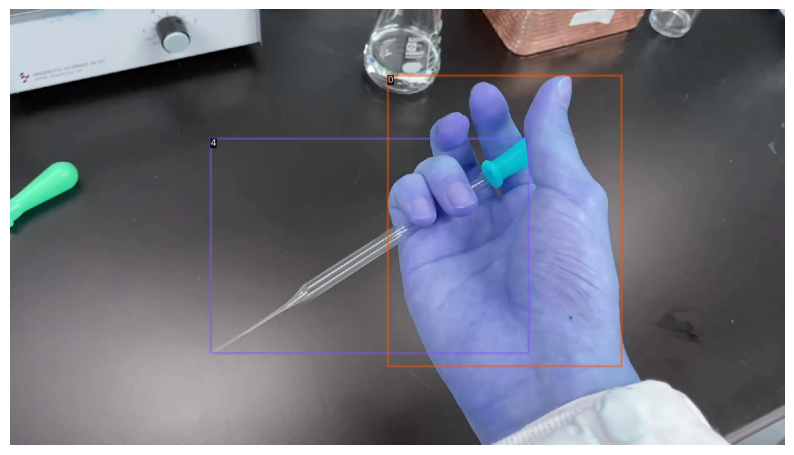

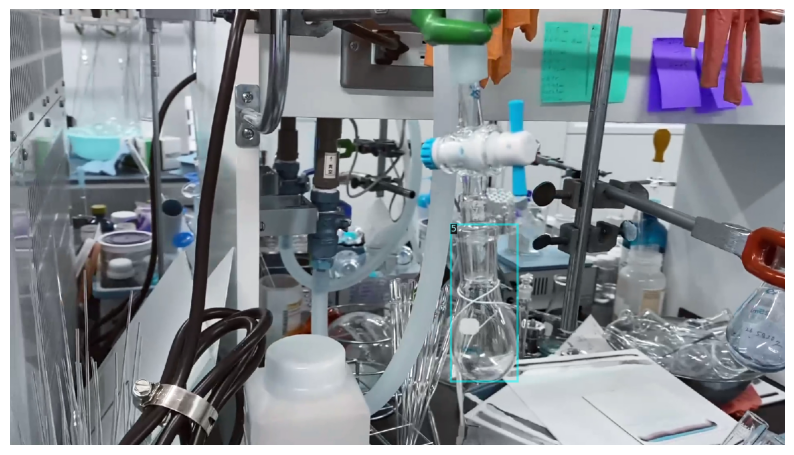

In [21]:
import matplotlib.pyplot as plt
import logging
from detectron2.utils.visualizer import ColorMode

logging.getLogger().setLevel(logging.WARNING)

dataset_dicts = DatasetCatalog.get("chemical_val")
metadata = MetadataCatalog.get("chemical_val")

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    v = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.8, instance_mode=ColorMode.IMAGE_BW)
    out = v.draw_dataset_dict(d)
    plt.figure(figsize=(10, 6))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.axis("off")
    plt.show()

# 📊 Сравнение из данных COCOEvaluator (взято из файлов в output)

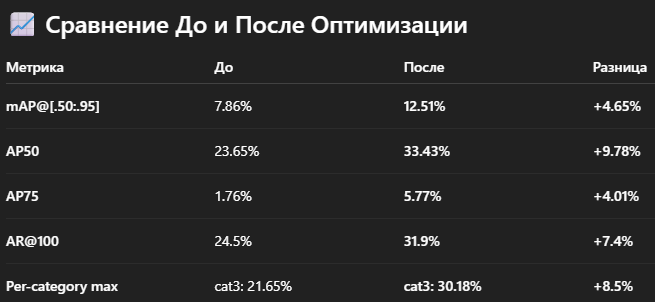